In [2]:
import numpy as np
import pandas as pd
import os
import sys

### Đọc dữ liệu

In [4]:
df = pd.read_csv("../data/onlret_transaction.csv", dtype={"CustomerID": str})

In [4]:
df.head(2)

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Status,CustomerType
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,1,1
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,1,1


In [4]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Quantity', 'InvoiceDate', 'UnitPrice',
       'CustomerID', 'Country', 'TotalPrice', 'Status', 'CustomerType'],
      dtype='object')

In [5]:
df[df.InvoiceNo == "573585"].head(5)

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Status,CustomerType
430237,573585,11001,2,2011-10-31 14:41:00,3.29,NaN,United Kingdom,6.58,1,0
430238,573585,15036,15,2011-10-31 14:41:00,1.63,NaN,United Kingdom,24.45,1,0
430239,573585,15039,15,2011-10-31 14:41:00,1.63,NaN,United Kingdom,24.45,1,0
430240,573585,15056BL,1,2011-10-31 14:41:00,12.46,NaN,United Kingdom,12.46,1,0
430241,573585,15056N,1,2011-10-31 14:41:00,12.46,NaN,United Kingdom,12.46,1,0


### Chứng minh nhận định

NỘI DUNG NHẬN ĐỊNH:

- Dữ liệu ban đầu **không là dạng chuỗi thời gian**, chỉ ở dạng transaction (giao dịch) thông thường.
- Khả năng chuyển đổi thành time-series: **Có**. Nếu xác định rõ đối tượng cần nghiên cứu (đối tượng phải tồn tại trong dữ liệu) thì sẽ biến đổi được về dạng time-series.


In [6]:
df.CustomerID.value_counts().head(7)

CustomerID
17841    7983
14911    5903
14096    5128
12748    4642
14606    2782
15311    2491
14646    2085
Name: count, dtype: int64

In [7]:
df[df.CustomerID == "14096"]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Status,CustomerType
317502,564764,16207B,1,2011-08-30 10:49:00,2.46,14096,United Kingdom,2.46,1,1
317503,564764,16225,1,2011-08-30 10:49:00,3.29,14096,United Kingdom,3.29,1,1
317504,564764,16254,1,2011-08-30 10:49:00,1.63,14096,United Kingdom,1.63,1,1
317505,564764,84249A,1,2011-08-30 10:49:00,0.83,14096,United Kingdom,0.83,1,1
317506,564764,84659A,2,2011-08-30 10:49:00,1.23,14096,United Kingdom,2.46,1,1
...,...,...,...,...,...,...,...,...,...,...
528083,580727,10135,8,2011-12-05 17:17:00,2.46,14096,United Kingdom,19.68,1,1
528084,580727,11001,3,2011-12-05 17:17:00,3.29,14096,United Kingdom,9.87,1,1
528085,580727,15044A,1,2011-12-05 17:17:00,5.79,14096,United Kingdom,5.79,1,1
528086,580727,15056BL,1,2011-12-05 17:17:00,12.46,14096,United Kingdom,12.46,1,1


### Chiến lược biến đổi thành data time-series

#### Chiến lược 1: Time-series ở mức hệ thống (System-level time series)

In [10]:
df["d"] = pd.to_datetime(df.InvoiceDate).dt.date

In [13]:
strategy_01 = df.groupby("d").agg(revenue = ("TotalPrice", "sum"), 
                    cnt_cus = ("CustomerID", "nunique"),
                    cnt_pro = ("StockCode", "nunique")
                   ).reset_index()

In [16]:
strategy_01.to_csv("../data/strategy_01.csv", index=False)

In [22]:
strategy_01.head()

,d,revenue,cnt_cus,cnt_pro
0,2010-12-01,58635.56,98,1351
1,2010-12-02,46207.28,117,934
2,2010-12-03,45620.46,55,1156
3,2010-12-05,31383.95,76,1151
4,2010-12-06,53860.18,90,1479


#### Chiến lược 2: Time-series theo sản phẩm (Product-level time series)

In [17]:
strategy_02 = df.groupby(by=["d", "StockCode"]).agg(revenue = ("TotalPrice", "sum"), 
                    cnt_cus = ("CustomerID", "nunique"),
                    cnt_pro = ("Quantity", "sum")
                   ).reset_index()

In [19]:
strategy_02.to_csv("../data/strategy_02.csv", index=False)

#### Chiến lược 3: Time-series theo khách hàng (Customer-level time series)

In [20]:
strategy_03 = df.groupby(by=["d", "CustomerID"]).agg(revenue = ("TotalPrice", "sum"), 
                    cnt_cus = ("StockCode", "nunique"),
                    cnt_pro = ("Quantity", "sum")
                   ).reset_index()

In [21]:
strategy_03.to_csv("../data/strategy_03.csv", index=False)

#### Chiến lược 4: Time-series đa biến (Multivariate time series)

In [24]:
strategy_04 = df.groupby("d").agg(revenue = ("TotalPrice", "sum"), 
                    cnt_cus = ("CustomerID", "nunique"),
                    cnt_pro = ("StockCode", "nunique"),
                    cnt = ("Quantity", "sum")      
                   ).reset_index()

In [25]:
strategy_04.to_csv("../data/strategy_04.csv", index=False)

### Yêu cầu 2-3

  InvoiceNo StockCode  Quantity         InvoiceDate  UnitPrice CustomerID  \
0    536365    85123A         6 2010-12-01 08:26:00       2.55      17850   
1    536365     71053         6 2010-12-01 08:26:00       3.39      17850   
2    536365    84406B         8 2010-12-01 08:26:00       2.75      17850   
3    536365    84029G         6 2010-12-01 08:26:00       3.39      17850   
4    536365    84029E         6 2010-12-01 08:26:00       3.39      17850   

          Country  TotalPrice  Status  CustomerType          d  
0  United Kingdom       15.30       1             1 2010-12-01  
1  United Kingdom       20.34       1             1 2010-12-01  
2  United Kingdom       22.00       1             1 2010-12-01  
3  United Kingdom       20.34       1             1 2010-12-01  
4  United Kingdom       20.34       1             1 2010-12-01  


/tmp/ipykernel_55/2340106410.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  strategy_01_monthly = strategy_01.resample("M").sum()


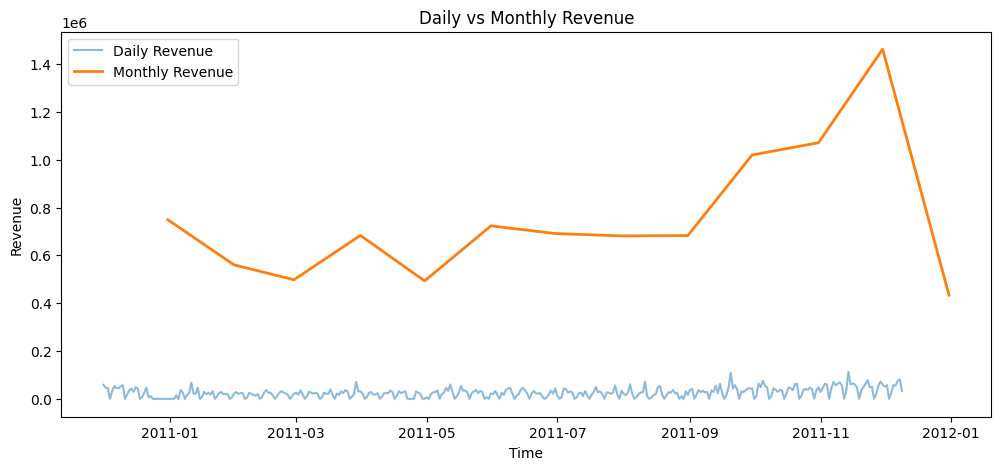

,Daily,Monthly
count,374.000000,1.300000e+01
mean,26063.497150,7.498268e+05
std,20031.204764,2.836729e+05
min,-1566.230000,4.336680e+05
25%,10410.657500,5.600003e+05
50%,25005.820000,6.832671e+05
75%,36982.692500,7.489570e+05
max,112141.110000,1.461756e+06
cv,0.768554,3.783179e-01


In [6]:
import matplotlib.pyplot as plt
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# 3. Create revenue variable
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# 4. Create daily time index
df["d"] = df["InvoiceDate"].dt.floor("D")
print(df.head())

# 5. Build DAILY system-level time series
strategy_01 = (
    df.groupby("d")
      .agg(
          revenue=("TotalPrice", "sum"),
          num_transactions=("InvoiceNo", "nunique")
      )
      .sort_index()
)

strategy_01.index = pd.to_datetime(strategy_01.index)
strategy_01 = strategy_01.asfreq("D", fill_value=0)

# 6. Build MONTHLY time series
strategy_01_monthly = strategy_01.resample("M").sum()

# 7. Plot Daily vs Monthly Revenue
plt.figure(figsize=(12,5))
plt.plot(strategy_01.index, strategy_01["revenue"], label="Daily Revenue", alpha=0.5)
plt.plot(strategy_01_monthly.index, strategy_01_monthly["revenue"], label="Monthly Revenue", linewidth=2)
plt.legend()
plt.title("Daily vs Monthly Revenue")
plt.xlabel("Time")
plt.ylabel("Revenue")
plt.show()

# 8. Quantitative comparison
comparison = pd.DataFrame({
    "Daily": strategy_01["revenue"].describe(),
    "Monthly": strategy_01_monthly["revenue"].describe()
})
comparison.loc["cv"] = comparison.loc["std"] / comparison.loc["mean"]

comparison

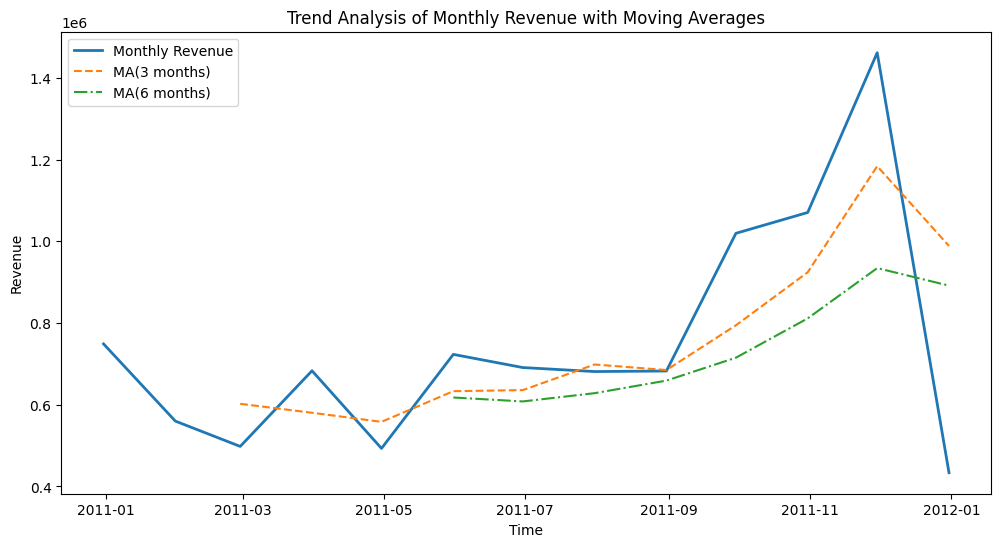

,Revenue,MA_3,MA_6
d,,,
2010-12-31,748957.020,NaN,NaN
2011-01-31,560000.260,NaN,NaN
2011-02-28,498062.650,602339.976667,NaN
2011-03-31,683267.080,580443.330000,NaN
2011-04-30,493207.121,558178.950333,NaN
2011-05-31,723333.510,633269.237000,617804.606833
2011-06-30,691123.120,635887.917000,608165.623500
2011-07-31,681300.111,698585.580333,628382.265333
2011-08-31,682680.510,685034.580333,659151.908667


In [7]:
import matplotlib.pyplot as plt
from IPython.display import display

# 1. Select monthly revenue time series
ts_revenue = strategy_01_monthly["revenue"]

# 2. Compute moving averages
ts_ma_3 = ts_revenue.rolling(window=3).mean()
ts_ma_6 = ts_revenue.rolling(window=6).mean()

# 3. Plot original series and moving averages
plt.figure(figsize=(12,6))
plt.plot(ts_revenue.index, ts_revenue, label="Monthly Revenue", linewidth=2)
plt.plot(ts_ma_3.index, ts_ma_3, label="MA(3 months)", linestyle="--")
plt.plot(ts_ma_6.index, ts_ma_6, label="MA(6 months)", linestyle="-.")
plt.legend()
plt.title("Trend Analysis of Monthly Revenue with Moving Averages")
plt.xlabel("Time")
plt.ylabel("Revenue")
plt.show()

# 4. Display head for inspection
display(
    pd.DataFrame({
        "Revenue": ts_revenue,
        "MA_3": ts_ma_3,
        "MA_6": ts_ma_6
    }).head(10)
)